In [37]:
import pandas as pd
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [38]:
# Mount Drive and Import Data

# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv("/content/drive/My Drive/STRIPS_data.csv")


df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')

In [39]:
# Data Preparation

maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
dt = '2025-02-04'
data_on_date = df[df['Date'] == dt]
times = [data_on_date[f'Time_{mat}'].values[0] for mat in maturities]
yields = [data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]
times = np.array(times)
yields = np.array(yields) * 100  # Convert to percentage
valid_idx = ~np.isnan(times) & ~np.isnan(yields)
times = times[valid_idx]
yields = yields[valid_idx]
print("Times (years):", times)
print("Yields (%):", yields)

Times (years): [ 0.52566735  1.52498289  2.52429843  3.52635181  4.52566735  5.52498289
  6.52429843  7.52635181  8.52566735  9.52498289 14.52429843  0.03011636
  1.0294319   2.02874743  3.02806297  4.03011636  6.02874743  7.02806297
  8.03011636  9.0294319  11.02806297 12.03011636 13.0294319  14.02874743
  0.27378508  1.27310062  2.27241615  3.27446954  4.27378508  5.27310062
  6.27241615  7.27446954  8.27378508  9.27310062 12.27378508 13.27310062
 14.27241615  0.77754962  1.77686516  2.7761807   3.77823409  5.77686516
  6.7761807   7.77823409  8.77754962  9.77686516]
Yields (%): [3.694 4.088 4.169 4.157 4.289 4.354 4.403 4.431 4.464 4.495 4.658 2.52
 4.081 3.973 4.252 4.173 4.357 4.419 4.448 4.483 4.371 4.451 4.548 4.597
 4.204 4.221 4.222 4.262 4.299 4.317 4.387 4.419 4.458 4.487 4.486 4.544
 4.645 4.243 3.887 4.182 4.277 4.345 4.417 4.409 4.464 4.499]


One-Factor HW Model

In [40]:
class HullWhiteModel:
    def __init__(self, r0, a, theta0, theta1, sigma):
        self.r0 = max(r0, 1e-6)
        self.a = max(a, 1e-6)
        self.theta0 = theta0      # constant part of theta(t)
        self.theta1 = theta1      # slope of theta(t)
        self.sigma = max(sigma, 1e-6)

    def theta(self, t):
        # Parametric form: theta(t)=theta0+theta1*t
        return self.theta0 + self.theta1 * t

    def B(self, t, T):
        # B(t,T)= (1-exp(-a*(T-t)))/a
        tau = T - t
        if tau <= 0:
            return 0
        return (1 - np.exp(-self.a * tau)) / self.a

    def A(self, t, T):
        # Compute the adjustment factor A(t,T) via numerical integration.
        # Here we integrate from u=t to T:
        #    ∫[theta(u)*B(u,T)-0.5*sigma^2*B(u,T)^2] du.
        if T - t <= 0:
            return 1.0
        us = np.linspace(t, T, 100)
        # For each u, compute B(u,T)
        B_vals = np.array([self.B(u, T) for u in us])
        theta_vals = self.theta(us)  # vectorized since theta is linear
        integrand = theta_vals * B_vals - 0.5 * self.sigma**2 * B_vals**2
        integral = np.trapz(integrand, us)
        return np.exp(integral)

    def zero(self, t, T, r_t):
        # Zero-coupon bond price: P(t,T)=A(t,T)*exp(-B(t,T)*r(t))
        B_val = self.B(t, T)
        A_val = self.A(t, T)
        p = A_val * np.exp(-B_val * r_t)
        return max(p, 1e-10)

    def yield_curve(self, T):
        # Yield defined as -ln(P(0,T))/T in percentage
        if T <= 0:
            return np.nan
        p = self.zero(0, T, self.r0)
        return -np.log(p)/T * 100

    def update_params(self, x):
        # x: [r0, a, theta0, theta1, sigma]
        self.r0 = max(x[0], 1e-6)
        self.a = max(x[1], 1e-6)
        self.theta0 = x[2]
        self.theta1 = x[3]
        self.sigma = max(x[4], 1e-6)

In [41]:
r0, a, theta0, theta1, sigma = 0.04, 0.05, 0.042, 0.001, 0.03
hw_nc_model = HullWhiteModel(r0, a, theta0, theta1, sigma)
model_yields = [hw_nc_model.yield_curve(t) for t in times]
print("Initial model yields (%):", model_yields[:5])

Initial model yields (%): [2.8530875630236765, 0.7236431071034323, -1.3428683303816504, -3.3560406542761148, -5.308746717853491]


In [43]:
def plot_yields(dt, obs_times, obs_yields, model, min_time=1e-4, max_time=15, num_points=100):
    time_grid = np.linspace(min_time, max_time, num_points)
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    strips_interp_yields = interp_func(time_grid)
    model_yields = [model.yield_curve(t) for t in time_grid]

    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    plt.plot(time_grid, strips_interp_yields, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    plt.plot(time_grid, model_yields, label='Hull-White Non-constant θ', linestyle='solid', color='orange')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve on {dt}')
    plt.grid(True)
    plt.show()

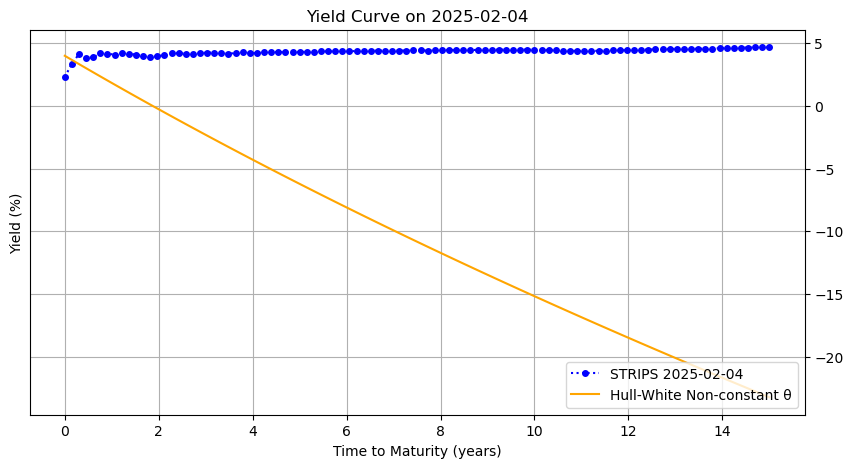

In [44]:
plot_yields(dt, times, yields, hw_nc_model)

In [62]:
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)
        self.times = np.array(obs_times)
        self.dist = dist
        self.model_yields = None
        self.n_params = 5

    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = [m.yield_curve(t) for t in self.times]
        return np.array(model_yields) - self.data
    
    def r_squared(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        y_mean = np.mean(self.data)
        ss_tot = np.sum((self.data - y_mean) ** 2)  # Total sum of squares
        ss_res = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    def rmse(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        return np.sqrt(np.mean((self.data - self.model_yields) ** 2))

    def aic(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        n = len(self.data)  # Number of observations
        rss = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        # AIC = n * ln(RSS/n) + 2 * k, where k is number of parameters
        return n * np.log(rss / n) + 2 * self.n_params if rss > 0 else np.nan

    def fit(self, x0, solver='trf'):
        # New parameter vector has 5 components.
        bounds = ([1e-6, 1e-6, -np.inf, -np.inf, 1e-6], [np.inf, np.inf, np.inf, np.inf, np.inf])
        result = least_squares(self.residuals, x0, bounds=bounds, method=solver)   
        self.model.update_params(result.x) 
        self.model_yields = np.array([self.model.yield_curve(t) for t in self.times])
        return 

Optimized parameters [r0, a, theta0, theta1, sigma]: [ 1.00000000e-06  1.01665729e+02 -2.09016987e+00 -7.72092657e-02
  2.06599884e+01]


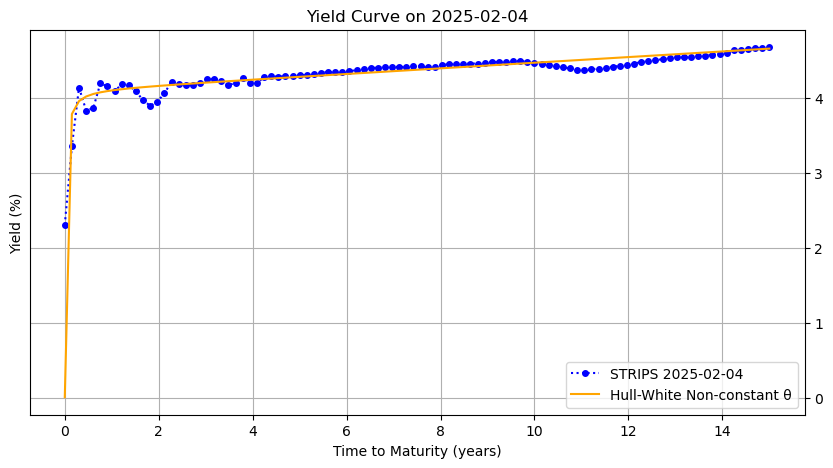

In [45]:
x0 = [0.04, 0.05, 0.042, 0.001, 0.03]
fitter = Fitter(hw_nc_model, yields, times)
fit_result = fitter.fit(x0)
print("Optimized parameters [r0, a, theta0, theta1, sigma]:", fit_result.x)
hw_nc_model.update_params(fit_result.x)
plot_yields(dt, times, yields, hw_nc_model)

In [46]:
# prompt: print out RMSE for the model above

from sklearn.metrics import mean_squared_error
import math

# ... (Your existing code) ...

# After fitting the model and updating parameters:
model_yields_fitted = [hw_nc_model.yield_curve(t) for t in times]
rmse = math.sqrt(mean_squared_error(yields, model_yields_fitted))
print("RMSE:", rmse)


RMSE: 0.09722777442203888


In [47]:
# prompt: print out the R^2 for the model

from sklearn.metrics import r2_score

# ... (Your existing code) ...

# After fitting the model and updating parameters:
model_yields_fitted = [hw_nc_model.yield_curve(t) for t in times]
r_squared = r2_score(yields, model_yields_fitted)
print("R-squared:", r_squared)


R-squared: 0.9106141157135875


In [48]:
# prompt: print out the AIC for the model

import numpy as np

# Assuming 'fit_result' is the result from the least_squares optimization
n_params = len(fit_result.x)  # Number of parameters in the model
n_obs = len(yields)  # Number of observations (yield data points)

# Calculate the residual sum of squares (RSS)
residuals = fit_result.fun
rss = np.sum(residuals**2)

# Calculate the AIC
aic = 2 * n_params + n_obs * np.log(rss / n_obs)

print("AIC:", aic)


AIC: -204.42429541903587


Two-Factor HW Model

In [49]:
## TWO FACTOR

class HullWhiteTwoFactorModelNonConst:
    def __init__(self, phi0, phi1, a, b, sigma_x, sigma_y, rho, x0=0.0, y0=0.0):
        self.phi0 = phi0      # constant part of the shift function φ(t)
        self.phi1 = phi1      # slope of the shift function
        self.a = max(a, 1e-6)
        self.b = max(b, 1e-6)
        self.sigma_x = max(sigma_x, 1e-6)
        self.sigma_y = max(sigma_y, 1e-6)
        self.rho = np.clip(rho, -0.999, 0.999)  # correlation between factors
        self.x0 = x0  # initial factor x(0) (typically set to 0)
        self.y0 = y0  # initial factor y(0) (typically set to 0)

    def phi(self, t):
        # Time-dependent shift: φ(t) = φ0 + φ1*t
        return self.phi0 + self.phi1 * t

    def B_x(self, u, T):
        # B_x(u,T) = (1 - exp(-a*(T-u)))/a
        tau = T - u
        if tau <= 0:
            return 0.0
        return (1 - np.exp(-self.a * tau)) / self.a

    def B_y(self, u, T):
        # B_y(u,T) = (1 - exp(-b*(T-u)))/b
        tau = T - u
        if tau <= 0:
            return 0.0
        return (1 - np.exp(-self.b * tau)) / self.b

    def A(self, T):
        """
        Computes the adjustment factor A(0,T) defined as:

        A(0,T) = exp( -∫₀ᵀ φ(u)du + 0.5 * [σₓ²Jₓₓ(T) + σ_y²J_y_y(T) + 2ρσₓσ_yJ_xy(T)] )
        where
          Jₓₓ(T) = ∫₀ᵀ [B_x(u,T)]² du,
          J_y_y(T) = ∫₀ᵀ [B_y(u,T)]² du,
          J_xy(T) = ∫₀ᵀ B_x(u,T) B_y(u,T) du.
        """
        if T <= 0:
            return 1.0
        num_steps = 100
        us = np.linspace(0, T, num_steps)
        # Numerical integration for ∫₀ᵀ φ(u)du
        phi_vals = self.phi(us)
        I_phi = np.trapz(phi_vals, us)
        # Compute B_x and B_y for each u
        Bx_vals = np.array([self.B_x(u, T) for u in us])
        By_vals = np.array([self.B_y(u, T) for u in us])
        # Numerical integrals for the variance adjustments
        J_xx = np.trapz(Bx_vals**2, us)
        J_yy = np.trapz(By_vals**2, us)
        J_xy = np.trapz(Bx_vals * By_vals, us)
        exponent = - I_phi + 0.5 * (self.sigma_x**2 * J_xx + self.sigma_y**2 * J_yy + 2 * self.rho * self.sigma_x * self.sigma_y * J_xy)
        return np.exp(exponent)

    def zero(self, T):
        # Zero-coupon bond price at time 0:
        # P(0,T) = A(0,T)*exp(-B_x(0,T)*x0 - B_y(0,T)*y0)
        Bx0 = self.B_x(0, T)
        By0 = self.B_y(0, T)
        p = self.A(T) * np.exp(-Bx0 * self.x0 - By0 * self.y0)
        return max(p, 1e-10)

    def yield_curve(self, T):
        # Yield (annualized) computed as: -ln(P(0,T))/T * 100
        if T <= 0:
            return np.nan
        p = self.zero(T)
        return -np.log(p)/T * 100

    def update_params(self, x):
        # Update the parameter vector: [phi0, phi1, a, b, sigma_x, sigma_y, rho]
        self.phi0 = x[0]
        self.phi1 = x[1]
        self.a = max(x[2], 1e-6)
        self.b = max(x[3], 1e-6)
        self.sigma_x = max(x[4], 1e-6)
        self.sigma_y = max(x[5], 1e-6)
        self.rho = np.clip(x[6], -0.999, 0.999)

In [50]:
# Test the two-factor model with initial parameters
# Initial guess: [phi0, phi1, a, b, sigma_x, sigma_y, rho]
phi0, phi1 = 0.03, 0.001
a, b = 0.05, 0.04
sigma_x, sigma_y = 0.03, 0.025
rho = 0.0
hw2f_model = HullWhiteTwoFactorModelNonConst(phi0, phi1, a, b, sigma_x, sigma_y, rho)
model_yields = [hw2f_model.yield_curve(t) for t in times]
print("Initial 2-factor model yields (%):", model_yields[:5])

Initial 2-factor model yields (%): [3.019385395745146, 3.0201413046016192, 2.977586956907689, 2.8958475417062988, 2.7794087707110493]


In [51]:
def plot_yields(dt, obs_times, obs_yields, model, min_time=1e-4, max_time=15, num_points=100):
    time_grid = np.linspace(min_time, max_time, num_points)
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    strips_interp_yields = interp_func(time_grid)
    model_yields = [model.yield_curve(t) for t in time_grid]

    plt.figure(figsize=(10, 5))
    plt.plot(time_grid, strips_interp_yields, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    plt.plot(time_grid, model_yields, label='2-Factor Hull–White Model', linestyle='solid', color='orange')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve on {dt}')
    plt.grid(True)
    plt.show()

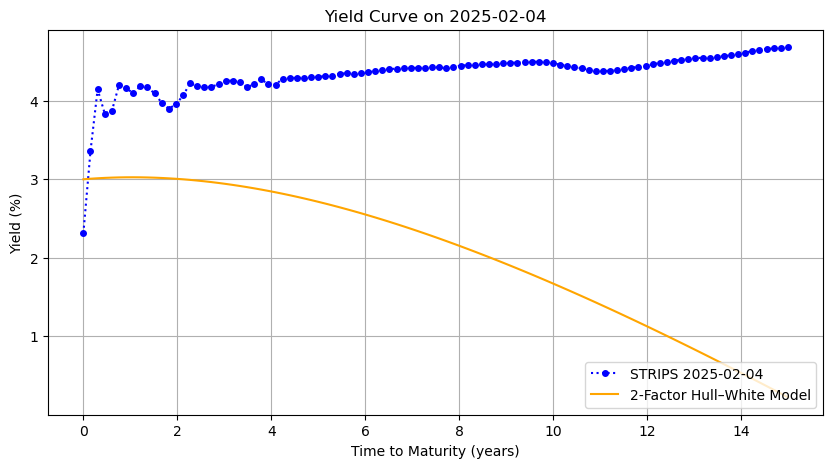

In [52]:
plot_yields(dt, times, yields, hw2f_model)

In [59]:
class Fitter2F:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)  # Observed yields
        self.times = np.array(obs_times)  # Maturities
        self.dist = dist
        self.model_yields = None  # Store predicted yields after fitting
        self.n_params = 8 

    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = [m.yield_curve(t) for t in self.times]
        return np.array(model_yields) - self.data
    
    def r_squared(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        y_mean = np.mean(self.data)
        ss_tot = np.sum((self.data - y_mean) ** 2)  # Total sum of squares
        ss_res = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    def rmse(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        return np.sqrt(np.mean((self.data - self.model_yields) ** 2))

    def aic(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        n = len(self.data)  # Number of observations
        rss = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        # AIC = n * ln(RSS/n) + 2 * k, where k is number of parameters
        return n * np.log(rss / n) + 2 * self.n_params if rss > 0 else np.nan

    def fit(self, x0, solver='trf'):
        # Parameter vector: [phi0, phi1, a, b, sigma_x, sigma_y, rho]
        bounds_lower = [-np.inf, -np.inf, 1e-6, 1e-6, 1e-6, 1e-6, -0.999]
        bounds_upper = [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 0.999]
        result = least_squares(self.residuals, x0, method=solver, bounds=(bounds_lower, bounds_upper))
        self.model.update_params(result.x)
        self.model_yields = np.array([self.model.yield_curve(t) for t in self.times])
        return result

Optimized parameters [phi0, phi1, a, b, sigma_x, sigma_y, rho]: [0.02676188 0.09659494 0.0734584  1.33732767 0.14427986 0.47764417
 0.999     ]
R-squared: 0.8415464202140494
RMSE (%): 0.1294514447770212
AIC: -172.08934590016685


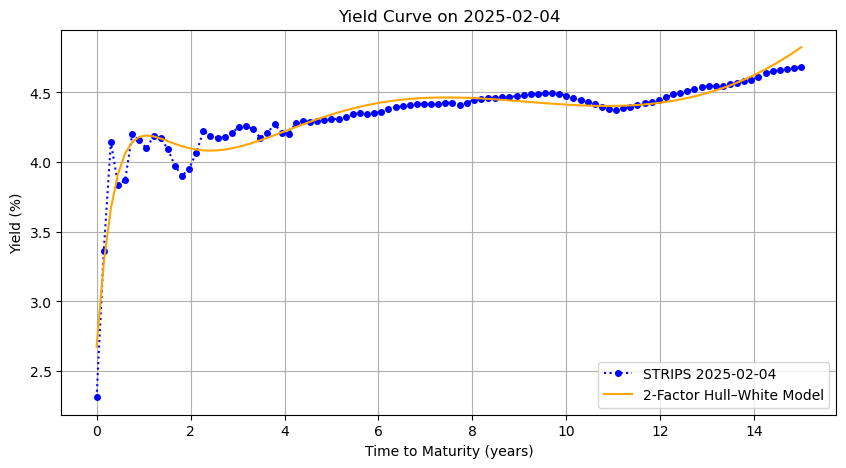

In [60]:
# Initial guess for calibration
x0 = [0.03, 0.001, 0.05, 0.04, 0.03, 0.025, 0.0]
fitter2f = Fitter2F(hw2f_model, yields, times, 'Q')
fit_result = fitter2f.fit(x0)
print("Optimized parameters [phi0, phi1, a, b, sigma_x, sigma_y, rho]:", fit_result.x)

print("R-squared:", fitter2f.r_squared())
print("RMSE (%):", fitter2f.rmse())
print("AIC:", fitter2f.aic())

metrics = {
    'R-squared': fitter2f.r_squared(),
    'RMSE': fitter2f.rmse(),
    'AIC': fitter2f.aic()
}

df_metrics = pd.DataFrame([metrics])
df_metrics.to_csv('hull_white_two_factor_metrics.csv', index=False)

# Update model and compute fitted yields
hw2f_model.update_params(fit_result.x)
plot_yields(dt, times, yields, hw2f_model)
